<div align="center">

### Lab 4

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 4: Predicting Stock Price with Deep Learning

</div>

### Introduction

In this lab, we explore the application of time-series datasets using Long Short-Term Memory (LSTM) networks, a type of recurrent neural network, to predict stock prices. Specifically, we will use historical price data from Nvidia to forecast the stock's price for the next day based on the prices of the previous N days. This approach is particularly relevant given the volatile nature of stock markets and the increasing reliance on automated trading systems.

### Objectives

- To understand the fundamentals of LSTM networks and their application in time-series forecasting.
- To develop a predictive model that can accurately forecast Nvidia's stock price for the next day using historical data.

### Dataset

The dataset for this lab is from the "Huge Stock Market Dataset" available on Kaggle. This dataset includes daily prices and volumes for all US stocks and ETFs, with a specific focus on Nvidia (NVDA). The dataset features include:

- **Date**: The recorded data points.
- **Open**: The price at which the stock first traded upon the opening of an exchange on a given trading day.
- **High**: The highest price at which the stock traded during the trading day.
- **Low**: The lowest price at which the stock traded during the trading day.
- **Close**: The price of the stock at closing time.
- **Volume**: The number of shares or contracts traded in a security or an entire market during a given period.
- **OpenInt**: The total number of outstanding derivative contracts, like options or futures. [More details here](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/discussion/121096)

### References

- [Huge Stock Market Dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs) for the dataset used in this lab.


## A. Checking and Preprocessing

In [761]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LassoCV

df = pd.read_csv('./nvda.us.txt')
df

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-01-22,1.6238,1.8092,1.4379,1.5215,18297633,0
1,1999-01-25,1.6423,1.6980,1.5215,1.6793,3445279,0
2,1999-01-26,1.6980,1.7350,1.5311,1.5494,2320993,0
3,1999-01-27,1.5586,1.5957,1.4660,1.5494,1662658,0
4,1999-01-28,1.5494,1.5586,1.5311,1.5401,1540110,0
...,...,...,...,...,...,...,...
4728,2017-11-06,207.2000,209.9800,206.7000,209.6300,9731783,0
4729,2017-11-07,210.5500,212.9000,210.0560,212.0000,10671815,0
4730,2017-11-08,211.8500,212.0000,207.2400,209.1600,13033902,0
4731,2017-11-09,205.2700,206.3300,200.3700,205.3200,23895006,0


In [762]:
# SEED
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False     

set_seed(1314520)

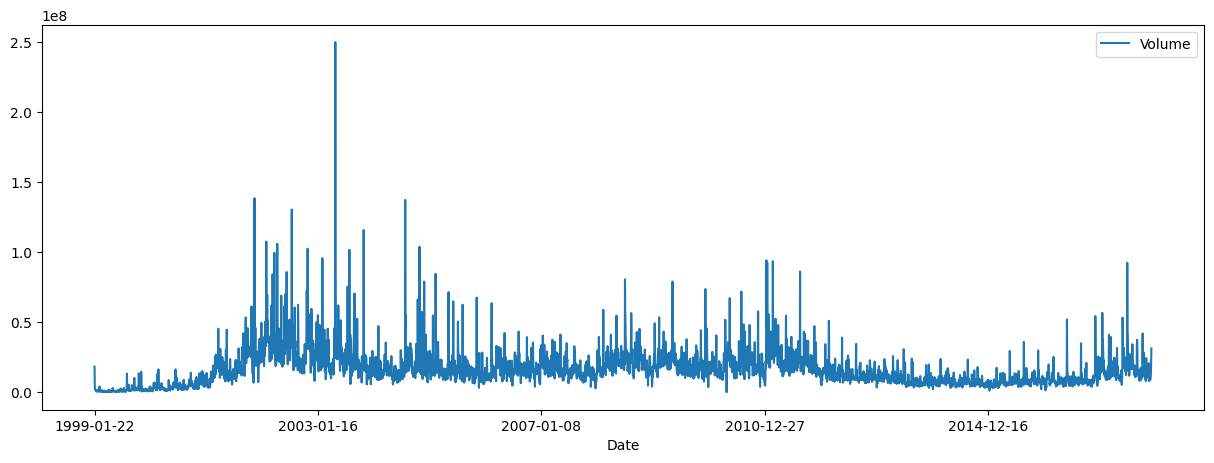

In [763]:
plot = df.plot('Date', 'Volume', figsize=(15, 5))

In [764]:
df[["High", "Low", "Open", "Close", "Volume"]].corr()

,High,Low,Open,Close,Volume
High,1.000000,0.999770,0.999862,0.999838,-0.004774
Low,0.999770,1.000000,0.999804,0.999863,-0.011785
Open,0.999862,0.999804,1.000000,0.999658,-0.007865
Close,0.999838,0.999863,0.999658,1.000000,-0.008339
Volume,-0.004774,-0.011785,-0.007865,-0.008339,1.000000


In [765]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')

In [766]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4733 entries, 0 to 4732
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4733 non-null   object 
 1   Open     4733 non-null   float64
 2   High     4733 non-null   float64
 3   Low      4733 non-null   float64
 4   Close    4733 non-null   float64
 5   Volume   4733 non-null   int64  
 6   OpenInt  4733 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 259.0+ KB


In [767]:
# checking for null values
df.isnull().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [768]:
df = df.dropna()

In [769]:
df.shape

(4733, 7)

In [770]:
df.describe()

,Open,High,Low,Close,Volume,OpenInt
count,4733.000000,4733.000000,4733.000000,4733.000000,4.733000e+03,4733.0
mean,20.796242,21.157332,20.420417,20.805404,1.615287e+07,0.0
std,30.236284,30.615622,29.792958,30.263705,1.272446e+07,0.0
min,1.298900,1.317500,1.233900,1.261900,0.000000e+00,0.0
25%,7.988300,8.247900,7.756400,7.978900,8.181100e+06,0.0
50%,12.963000,13.238000,12.721000,12.990000,1.390271e+07,0.0
75%,19.141000,19.418000,18.778000,19.106000,2.051602e+07,0.0
max,213.080000,218.670000,211.630000,216.140000,2.496659e+08,0.0


#### Converting the DataFrame to a NumPy Array

In [771]:
def create_sequences(input_data, output_data, window_size, step):
    
    print(f"Input Data Size: {input_data.shape}, Output Data Size: {output_data.shape}, Window Size: {window_size}, Step: {step}")
    
    sequences = []
    labels = []
    for i in range(0, len(input_data) - window_size, step):
        sequences.append(input_data[i:(i + window_size)])
        labels.append(output_data[i + window_size])
    return np.array(sequences), np.array(labels)

In [772]:
# Select features
features = df[['Open', 'High', 'Low', "Close"]]
labels = df['High'].shift(-1)  # Next day's high price as label

X, y = create_sequences(features, labels, window_size=8, step=10)

print(f'Shape of data X: {X.shape}')
print(f'Shape of data y: {y.shape}')

# split the hold-out tests
ind = np.linspace(0, len(X)-1, num=int(len(X)*0.1), dtype=int) # 10% hold-out
x_test = X[ind]
y_test = y[ind]
all_ind = np.arange(len(X))
remains_ind = np.delete(all_ind, ind)

X = X[remains_ind]
y = y[remains_ind]

# shuffle dataset
ind = np.random.permutation(len(X))
X = X[ind]
y = y[ind]
split_point = int(X.shape[0]*0.8)

x_train = X[:split_point]
y_train = y[:split_point]
x_val = X[split_point:]
y_val = y[split_point:]

train_mean = x_train.mean(axis=(0, 1), keepdims=True)
train_std = x_train.std(axis=(0, 1), keepdims=True)

x_train = (x_train - train_mean) / (train_std + 1e-8)
x_val = (x_val - train_mean) / (train_std + 1e-8)
x_test = (x_test - train_mean) / (train_std + 1e-8)

print(f'Shape of data x_train: {x_train.shape}')
print(f'Shape of data y_train: {y_train.shape}')
print(f'Shape of data x_val: {x_val.shape}')
print(f'Shape of data y_val: {y_val.shape}')
print(f'Shape of data x_test: {x_test.shape}')
print(f'Shape of data y_test: {y_test.shape}')

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

x_test = torch.from_numpy(x_test).float()
y_test = torch.from_numpy(y_test).float()

batch_size = 32

# Create datasets
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
test_dataset = TensorDataset(x_test, y_test)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f'Number of samples in training and validation are {len(train_loader.dataset)} and {len(val_loader.dataset)}.')

Input Data Size: (4733, 4), Output Data Size: (4733,), Window Size: 8, Step: 10
Shape of data X: (473, 8, 4)
Shape of data y: (473,)
Shape of data x_train: (340, 8, 4)
Shape of data y_train: (340,)
Shape of data x_val: (86, 8, 4)
Shape of data y_val: (86,)
Shape of data x_test: (47, 8, 4)
Shape of data y_test: (47,)
Number of samples in training and validation are 340 and 86.


## B. Defining Neural Networks

In [773]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

## C. Training the Neural Network

In [774]:
# Check your GPU status.
!nvidia-smi

Mon Apr 28 20:50:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   31C    P8             14W /  130W |    1573MiB /   8192MiB |     23%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [775]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []

epochs = 200

model = LSTMModel(input_dim=4, hidden_dim=500, num_layers=2, output_dim=1).cuda()
print(model)

best_val_loss = float('inf')
best_train_loss = float('inf')

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0)

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0

    for features, labels in train_loader:
        features = features.cuda()
        labels = labels.cuda()
        outputs = model(features).squeeze(-1)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning rate update
    lr_scheduler.step()

    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.cuda()
            labels = labels.cuda()
            outputs = model(features).squeeze(-1)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_train_loss = avg_train_loss
        torch.save(model.state_dict(), 'best_model.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Val loss: {avg_val_loss:.4f}, Best Train loss: {best_train_loss:.4f}, Best Val loss: {best_val_loss:.4f}')

    # Store performance
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

LSTMModel(
  (lstm): LSTM(4, 500, num_layers=2, batch_first=True)
  (fc): Linear(in_features=500, out_features=1, bias=True)
)


  2%|▏         | 3/200 [00:00<00:20,  9.38it/s]

Epoch 1/200, Train loss: 964.6708, Val loss: 1539.8115, Best Train loss: 964.6708, Best Val loss: 1539.8115
Epoch 2/200, Train loss: 722.8451, Val loss: 1419.8623, Best Train loss: 722.8451, Best Val loss: 1419.8623
Epoch 3/200, Train loss: 718.6448, Val loss: 1376.4860, Best Train loss: 718.6448, Best Val loss: 1376.4860
Epoch 4/200, Train loss: 699.5586, Val loss: 1311.9146, Best Train loss: 699.5586, Best Val loss: 1311.9146


  4%|▎         | 7/200 [00:00<00:13, 14.38it/s]

Epoch 5/200, Train loss: 705.0802, Val loss: 1269.0385, Best Train loss: 705.0802, Best Val loss: 1269.0385
Epoch 6/200, Train loss: 611.9094, Val loss: 1191.4956, Best Train loss: 611.9094, Best Val loss: 1191.4956
Epoch 7/200, Train loss: 609.2347, Val loss: 1099.1930, Best Train loss: 609.2347, Best Val loss: 1099.1930
Epoch 8/200, Train loss: 520.2670, Val loss: 1014.2051, Best Train loss: 520.2670, Best Val loss: 1014.2051


  6%|▌         | 11/200 [00:00<00:11, 16.44it/s]

Epoch 9/200, Train loss: 466.2399, Val loss: 937.7961, Best Train loss: 466.2399, Best Val loss: 937.7961
Epoch 10/200, Train loss: 415.8795, Val loss: 867.9905, Best Train loss: 415.8795, Best Val loss: 867.9905
Epoch 11/200, Train loss: 419.4483, Val loss: 803.4603, Best Train loss: 419.4483, Best Val loss: 803.4603
Epoch 12/200, Train loss: 372.8742, Val loss: 745.4990, Best Train loss: 372.8742, Best Val loss: 745.4990


  8%|▊         | 15/200 [00:01<00:10, 17.25it/s]

Epoch 13/200, Train loss: 333.0287, Val loss: 690.8641, Best Train loss: 333.0287, Best Val loss: 690.8641
Epoch 14/200, Train loss: 301.3971, Val loss: 647.4329, Best Train loss: 301.3971, Best Val loss: 647.4329
Epoch 15/200, Train loss: 303.6430, Val loss: 607.4566, Best Train loss: 303.6430, Best Val loss: 607.4566
Epoch 16/200, Train loss: 263.8494, Val loss: 567.5149, Best Train loss: 263.8494, Best Val loss: 567.5149


 10%|▉         | 19/200 [00:01<00:10, 17.54it/s]

Epoch 17/200, Train loss: 249.7750, Val loss: 532.0023, Best Train loss: 249.7750, Best Val loss: 532.0023
Epoch 18/200, Train loss: 235.2245, Val loss: 497.5771, Best Train loss: 235.2245, Best Val loss: 497.5771
Epoch 19/200, Train loss: 244.7917, Val loss: 471.8897, Best Train loss: 244.7917, Best Val loss: 471.8897
Epoch 20/200, Train loss: 205.3038, Val loss: 442.1609, Best Train loss: 205.3038, Best Val loss: 442.1609


 12%|█▏        | 23/200 [00:01<00:10, 17.48it/s]

Epoch 21/200, Train loss: 216.8976, Val loss: 410.7738, Best Train loss: 216.8976, Best Val loss: 410.7738
Epoch 22/200, Train loss: 191.1427, Val loss: 385.5905, Best Train loss: 191.1427, Best Val loss: 385.5905
Epoch 23/200, Train loss: 172.0020, Val loss: 363.1885, Best Train loss: 172.0020, Best Val loss: 363.1885
Epoch 24/200, Train loss: 186.2407, Val loss: 340.5037, Best Train loss: 186.2407, Best Val loss: 340.5037


 14%|█▎        | 27/200 [00:01<00:09, 17.94it/s]

Epoch 25/200, Train loss: 153.3503, Val loss: 322.7066, Best Train loss: 153.3503, Best Val loss: 322.7066
Epoch 26/200, Train loss: 142.8253, Val loss: 299.9305, Best Train loss: 142.8253, Best Val loss: 299.9305
Epoch 27/200, Train loss: 133.2401, Val loss: 284.3170, Best Train loss: 133.2401, Best Val loss: 284.3170
Epoch 28/200, Train loss: 138.3039, Val loss: 268.0383, Best Train loss: 138.3039, Best Val loss: 268.0383


 16%|█▌        | 31/200 [00:01<00:09, 18.10it/s]

Epoch 29/200, Train loss: 121.2018, Val loss: 253.0680, Best Train loss: 121.2018, Best Val loss: 253.0680
Epoch 30/200, Train loss: 113.0088, Val loss: 238.2003, Best Train loss: 113.0088, Best Val loss: 238.2003
Epoch 31/200, Train loss: 117.5515, Val loss: 230.4084, Best Train loss: 117.5515, Best Val loss: 230.4084
Epoch 32/200, Train loss: 104.1078, Val loss: 216.9463, Best Train loss: 104.1078, Best Val loss: 216.9463


 18%|█▊        | 35/200 [00:02<00:09, 18.13it/s]

Epoch 33/200, Train loss: 104.5591, Val loss: 207.8388, Best Train loss: 104.5591, Best Val loss: 207.8388
Epoch 34/200, Train loss: 98.6226, Val loss: 200.6843, Best Train loss: 98.6226, Best Val loss: 200.6843
Epoch 35/200, Train loss: 95.0241, Val loss: 194.6966, Best Train loss: 95.0241, Best Val loss: 194.6966
Epoch 36/200, Train loss: 99.8770, Val loss: 178.3684, Best Train loss: 99.8770, Best Val loss: 178.3684


 20%|█▉        | 39/200 [00:02<00:08, 17.91it/s]

Epoch 37/200, Train loss: 82.1676, Val loss: 169.3284, Best Train loss: 82.1676, Best Val loss: 169.3284
Epoch 38/200, Train loss: 91.0423, Val loss: 161.1203, Best Train loss: 91.0423, Best Val loss: 161.1203
Epoch 39/200, Train loss: 74.0841, Val loss: 157.0102, Best Train loss: 74.0841, Best Val loss: 157.0102
Epoch 40/200, Train loss: 72.8877, Val loss: 146.4995, Best Train loss: 72.8877, Best Val loss: 146.4995


 22%|██▏       | 43/200 [00:02<00:08, 18.42it/s]

Epoch 41/200, Train loss: 68.6839, Val loss: 141.8482, Best Train loss: 68.6839, Best Val loss: 141.8482
Epoch 42/200, Train loss: 75.8372, Val loss: 186.0999, Best Train loss: 68.6839, Best Val loss: 141.8482
Epoch 43/200, Train loss: 90.1009, Val loss: 139.9468, Best Train loss: 90.1009, Best Val loss: 139.9468
Epoch 44/200, Train loss: 75.7507, Val loss: 152.2109, Best Train loss: 90.1009, Best Val loss: 139.9468
Epoch 45/200, Train loss: 75.8478, Val loss: 153.0270, Best Train loss: 90.1009, Best Val loss: 139.9468


 24%|██▍       | 49/200 [00:02<00:07, 19.57it/s]

Epoch 46/200, Train loss: 100.3784, Val loss: 147.5858, Best Train loss: 90.1009, Best Val loss: 139.9468
Epoch 47/200, Train loss: 86.4248, Val loss: 158.1516, Best Train loss: 90.1009, Best Val loss: 139.9468
Epoch 48/200, Train loss: 73.1490, Val loss: 132.0491, Best Train loss: 73.1490, Best Val loss: 132.0491
Epoch 49/200, Train loss: 63.3613, Val loss: 123.2842, Best Train loss: 63.3613, Best Val loss: 123.2842
Epoch 50/200, Train loss: 67.9274, Val loss: 117.5632, Best Train loss: 67.9274, Best Val loss: 117.5632


 26%|██▋       | 53/200 [00:03<00:07, 18.56it/s]

Epoch 51/200, Train loss: 57.1980, Val loss: 108.7958, Best Train loss: 57.1980, Best Val loss: 108.7958
Epoch 52/200, Train loss: 52.7853, Val loss: 104.2814, Best Train loss: 52.7853, Best Val loss: 104.2814
Epoch 53/200, Train loss: 53.5861, Val loss: 102.1788, Best Train loss: 53.5861, Best Val loss: 102.1788
Epoch 54/200, Train loss: 48.4798, Val loss: 92.8704, Best Train loss: 48.4798, Best Val loss: 92.8704


 28%|██▊       | 57/200 [00:03<00:07, 17.97it/s]

Epoch 55/200, Train loss: 45.7338, Val loss: 88.7334, Best Train loss: 45.7338, Best Val loss: 88.7334
Epoch 56/200, Train loss: 54.4671, Val loss: 84.5135, Best Train loss: 54.4671, Best Val loss: 84.5135
Epoch 57/200, Train loss: 41.4773, Val loss: 77.7949, Best Train loss: 41.4773, Best Val loss: 77.7949
Epoch 58/200, Train loss: 41.5090, Val loss: 78.2973, Best Train loss: 41.4773, Best Val loss: 77.7949


 30%|███       | 61/200 [00:03<00:07, 18.31it/s]

Epoch 59/200, Train loss: 39.6494, Val loss: 69.2830, Best Train loss: 39.6494, Best Val loss: 69.2830
Epoch 60/200, Train loss: 44.6676, Val loss: 68.9406, Best Train loss: 44.6676, Best Val loss: 68.9406
Epoch 61/200, Train loss: 39.6890, Val loss: 62.5788, Best Train loss: 39.6890, Best Val loss: 62.5788
Epoch 62/200, Train loss: 33.8185, Val loss: 68.5522, Best Train loss: 39.6890, Best Val loss: 62.5788
Epoch 63/200, Train loss: 32.6645, Val loss: 55.7580, Best Train loss: 32.6645, Best Val loss: 55.7580


 33%|███▎      | 66/200 [00:03<00:07, 18.54it/s]

Epoch 64/200, Train loss: 35.7535, Val loss: 55.2208, Best Train loss: 35.7535, Best Val loss: 55.2208
Epoch 65/200, Train loss: 29.1933, Val loss: 51.1647, Best Train loss: 29.1933, Best Val loss: 51.1647
Epoch 66/200, Train loss: 33.7907, Val loss: 48.6732, Best Train loss: 33.7907, Best Val loss: 48.6732
Epoch 67/200, Train loss: 31.3993, Val loss: 45.3989, Best Train loss: 31.3993, Best Val loss: 45.3989


 35%|███▌      | 70/200 [00:04<00:07, 18.48it/s]

Epoch 68/200, Train loss: 25.9353, Val loss: 44.3633, Best Train loss: 25.9353, Best Val loss: 44.3633
Epoch 69/200, Train loss: 24.7573, Val loss: 40.5495, Best Train loss: 24.7573, Best Val loss: 40.5495
Epoch 70/200, Train loss: 23.7595, Val loss: 40.2401, Best Train loss: 23.7595, Best Val loss: 40.2401
Epoch 71/200, Train loss: 22.8122, Val loss: 37.9891, Best Train loss: 22.8122, Best Val loss: 37.9891


 38%|███▊      | 75/200 [00:04<00:06, 19.07it/s]

Epoch 72/200, Train loss: 21.8926, Val loss: 34.7190, Best Train loss: 21.8926, Best Val loss: 34.7190
Epoch 73/200, Train loss: 21.6813, Val loss: 35.9843, Best Train loss: 21.8926, Best Val loss: 34.7190
Epoch 74/200, Train loss: 20.8409, Val loss: 32.4222, Best Train loss: 20.8409, Best Val loss: 32.4222
Epoch 75/200, Train loss: 22.4347, Val loss: 33.0564, Best Train loss: 20.8409, Best Val loss: 32.4222
Epoch 76/200, Train loss: 20.6320, Val loss: 32.4999, Best Train loss: 20.8409, Best Val loss: 32.4222


 39%|███▉      | 78/200 [00:04<00:06, 19.25it/s]

Epoch 77/200, Train loss: 19.4937, Val loss: 27.9176, Best Train loss: 19.4937, Best Val loss: 27.9176
Epoch 78/200, Train loss: 19.0500, Val loss: 26.2483, Best Train loss: 19.0500, Best Val loss: 26.2483
Epoch 79/200, Train loss: 18.6154, Val loss: 29.1997, Best Train loss: 19.0500, Best Val loss: 26.2483
Epoch 80/200, Train loss: 17.1351, Val loss: 23.7077, Best Train loss: 17.1351, Best Val loss: 23.7077


 42%|████▎     | 85/200 [00:04<00:05, 19.20it/s]

Epoch 81/200, Train loss: 16.4201, Val loss: 23.4248, Best Train loss: 16.4201, Best Val loss: 23.4248
Epoch 82/200, Train loss: 16.4117, Val loss: 21.7424, Best Train loss: 16.4117, Best Val loss: 21.7424
Epoch 83/200, Train loss: 18.8766, Val loss: 21.9228, Best Train loss: 16.4117, Best Val loss: 21.7424
Epoch 84/200, Train loss: 15.3059, Val loss: 19.7820, Best Train loss: 15.3059, Best Val loss: 19.7820
Epoch 85/200, Train loss: 14.7556, Val loss: 19.3817, Best Train loss: 14.7556, Best Val loss: 19.3817


 44%|████▍     | 89/200 [00:05<00:05, 18.74it/s]

Epoch 86/200, Train loss: 14.3665, Val loss: 18.6874, Best Train loss: 14.3665, Best Val loss: 18.6874
Epoch 87/200, Train loss: 13.8584, Val loss: 17.7668, Best Train loss: 13.8584, Best Val loss: 17.7668
Epoch 88/200, Train loss: 13.4744, Val loss: 17.5225, Best Train loss: 13.4744, Best Val loss: 17.5225
Epoch 89/200, Train loss: 13.3135, Val loss: 16.7315, Best Train loss: 13.3135, Best Val loss: 16.7315


 46%|████▋     | 93/200 [00:05<00:06, 17.60it/s]

Epoch 90/200, Train loss: 13.0036, Val loss: 15.5959, Best Train loss: 13.0036, Best Val loss: 15.5959
Epoch 91/200, Train loss: 12.5620, Val loss: 15.5215, Best Train loss: 12.5620, Best Val loss: 15.5215
Epoch 92/200, Train loss: 12.5740, Val loss: 14.7601, Best Train loss: 12.5740, Best Val loss: 14.7601
Epoch 93/200, Train loss: 11.9748, Val loss: 14.1785, Best Train loss: 11.9748, Best Val loss: 14.1785


 48%|████▊     | 97/200 [00:05<00:05, 17.88it/s]

Epoch 94/200, Train loss: 11.8382, Val loss: 14.5015, Best Train loss: 11.9748, Best Val loss: 14.1785
Epoch 95/200, Train loss: 14.7087, Val loss: 13.1550, Best Train loss: 14.7087, Best Val loss: 13.1550
Epoch 96/200, Train loss: 11.3066, Val loss: 12.5303, Best Train loss: 11.3066, Best Val loss: 12.5303
Epoch 97/200, Train loss: 11.1798, Val loss: 12.5186, Best Train loss: 11.1798, Best Val loss: 12.5186


 50%|█████     | 101/200 [00:05<00:05, 18.40it/s]

Epoch 98/200, Train loss: 10.8184, Val loss: 12.2986, Best Train loss: 10.8184, Best Val loss: 12.2986
Epoch 99/200, Train loss: 12.8148, Val loss: 11.1235, Best Train loss: 12.8148, Best Val loss: 11.1235
Epoch 100/200, Train loss: 10.4922, Val loss: 12.8031, Best Train loss: 12.8148, Best Val loss: 11.1235
Epoch 101/200, Train loss: 10.2031, Val loss: 10.3308, Best Train loss: 10.2031, Best Val loss: 10.3308
Epoch 102/200, Train loss: 10.0527, Val loss: 10.4068, Best Train loss: 10.2031, Best Val loss: 10.3308


 54%|█████▎    | 107/200 [00:05<00:04, 18.89it/s]

Epoch 103/200, Train loss: 9.8091, Val loss: 10.1612, Best Train loss: 9.8091, Best Val loss: 10.1612
Epoch 104/200, Train loss: 9.6862, Val loss: 9.9572, Best Train loss: 9.6862, Best Val loss: 9.9572
Epoch 105/200, Train loss: 9.5438, Val loss: 9.7024, Best Train loss: 9.5438, Best Val loss: 9.7024
Epoch 106/200, Train loss: 9.4027, Val loss: 9.1924, Best Train loss: 9.4027, Best Val loss: 9.1924
Epoch 107/200, Train loss: 9.3931, Val loss: 10.0092, Best Train loss: 9.4027, Best Val loss: 9.1924


 56%|█████▌    | 111/200 [00:06<00:04, 19.03it/s]

Epoch 108/200, Train loss: 9.2304, Val loss: 8.7069, Best Train loss: 9.2304, Best Val loss: 8.7069
Epoch 109/200, Train loss: 9.0283, Val loss: 8.5875, Best Train loss: 9.0283, Best Val loss: 8.5875
Epoch 110/200, Train loss: 8.8868, Val loss: 8.8932, Best Train loss: 9.0283, Best Val loss: 8.5875
Epoch 111/200, Train loss: 8.7688, Val loss: 8.5496, Best Train loss: 8.7688, Best Val loss: 8.5496
Epoch 112/200, Train loss: 8.7301, Val loss: 7.7010, Best Train loss: 8.7301, Best Val loss: 7.7010


 58%|█████▊    | 117/200 [00:06<00:04, 19.52it/s]

Epoch 113/200, Train loss: 8.9222, Val loss: 8.9182, Best Train loss: 8.7301, Best Val loss: 7.7010
Epoch 114/200, Train loss: 8.7745, Val loss: 7.5627, Best Train loss: 8.7745, Best Val loss: 7.5627
Epoch 115/200, Train loss: 8.5237, Val loss: 7.7911, Best Train loss: 8.7745, Best Val loss: 7.5627
Epoch 116/200, Train loss: 8.3023, Val loss: 7.8881, Best Train loss: 8.7745, Best Val loss: 7.5627
Epoch 117/200, Train loss: 8.1849, Val loss: 7.3295, Best Train loss: 8.1849, Best Val loss: 7.3295


 60%|██████    | 121/200 [00:06<00:04, 18.79it/s]

Epoch 118/200, Train loss: 8.0368, Val loss: 7.4077, Best Train loss: 8.1849, Best Val loss: 7.3295
Epoch 119/200, Train loss: 7.9390, Val loss: 7.1303, Best Train loss: 7.9390, Best Val loss: 7.1303
Epoch 120/200, Train loss: 7.8554, Val loss: 6.8051, Best Train loss: 7.8554, Best Val loss: 6.8051
Epoch 121/200, Train loss: 7.8358, Val loss: 7.2297, Best Train loss: 7.8554, Best Val loss: 6.8051


 62%|██████▎   | 125/200 [00:06<00:03, 19.06it/s]

Epoch 122/200, Train loss: 7.8544, Val loss: 6.7532, Best Train loss: 7.8544, Best Val loss: 6.7532
Epoch 123/200, Train loss: 7.6845, Val loss: 6.9266, Best Train loss: 7.8544, Best Val loss: 6.7532
Epoch 124/200, Train loss: 9.1617, Val loss: 6.2934, Best Train loss: 9.1617, Best Val loss: 6.2934
Epoch 125/200, Train loss: 9.1479, Val loss: 6.5534, Best Train loss: 9.1617, Best Val loss: 6.2934
Epoch 126/200, Train loss: 7.5176, Val loss: 6.4008, Best Train loss: 9.1617, Best Val loss: 6.2934


 65%|██████▌   | 130/200 [00:07<00:03, 19.29it/s]

Epoch 127/200, Train loss: 9.4999, Val loss: 6.1894, Best Train loss: 9.4999, Best Val loss: 6.1894
Epoch 128/200, Train loss: 9.4034, Val loss: 5.7008, Best Train loss: 9.4034, Best Val loss: 5.7008
Epoch 129/200, Train loss: 7.3864, Val loss: 5.6774, Best Train loss: 7.3864, Best Val loss: 5.6774
Epoch 130/200, Train loss: 8.2928, Val loss: 5.8031, Best Train loss: 7.3864, Best Val loss: 5.6774
Epoch 131/200, Train loss: 10.2556, Val loss: 6.5137, Best Train loss: 7.3864, Best Val loss: 5.6774


 68%|██████▊   | 136/200 [00:07<00:03, 20.47it/s]

Epoch 132/200, Train loss: 7.3499, Val loss: 5.8559, Best Train loss: 7.3864, Best Val loss: 5.6774
Epoch 133/200, Train loss: 7.2288, Val loss: 5.5823, Best Train loss: 7.2288, Best Val loss: 5.5823
Epoch 134/200, Train loss: 7.0947, Val loss: 5.8340, Best Train loss: 7.2288, Best Val loss: 5.5823
Epoch 135/200, Train loss: 8.4464, Val loss: 5.9016, Best Train loss: 7.2288, Best Val loss: 5.5823
Epoch 136/200, Train loss: 8.3888, Val loss: 5.7121, Best Train loss: 7.2288, Best Val loss: 5.5823


 70%|██████▉   | 139/200 [00:07<00:03, 19.85it/s]

Epoch 137/200, Train loss: 9.0006, Val loss: 5.5130, Best Train loss: 9.0006, Best Val loss: 5.5130
Epoch 138/200, Train loss: 6.9167, Val loss: 5.8310, Best Train loss: 9.0006, Best Val loss: 5.5130
Epoch 139/200, Train loss: 6.8927, Val loss: 5.4217, Best Train loss: 6.8927, Best Val loss: 5.4217
Epoch 140/200, Train loss: 6.8800, Val loss: 5.6184, Best Train loss: 6.8927, Best Val loss: 5.4217
Epoch 141/200, Train loss: 8.7653, Val loss: 5.8643, Best Train loss: 6.8927, Best Val loss: 5.4217


 72%|███████▎  | 145/200 [00:07<00:02, 19.87it/s]

Epoch 142/200, Train loss: 6.8294, Val loss: 5.3468, Best Train loss: 6.8294, Best Val loss: 5.3468
Epoch 143/200, Train loss: 6.7801, Val loss: 5.6352, Best Train loss: 6.8294, Best Val loss: 5.3468
Epoch 144/200, Train loss: 6.7765, Val loss: 5.5584, Best Train loss: 6.8294, Best Val loss: 5.3468
Epoch 145/200, Train loss: 8.5733, Val loss: 5.2047, Best Train loss: 8.5733, Best Val loss: 5.2047
Epoch 146/200, Train loss: 6.7198, Val loss: 5.3659, Best Train loss: 8.5733, Best Val loss: 5.2047


 76%|███████▌  | 151/200 [00:08<00:02, 20.91it/s]

Epoch 147/200, Train loss: 6.6871, Val loss: 5.2906, Best Train loss: 8.5733, Best Val loss: 5.2047
Epoch 148/200, Train loss: 6.6489, Val loss: 5.7582, Best Train loss: 8.5733, Best Val loss: 5.2047
Epoch 149/200, Train loss: 6.6489, Val loss: 5.2423, Best Train loss: 8.5733, Best Val loss: 5.2047
Epoch 150/200, Train loss: 6.6530, Val loss: 5.3151, Best Train loss: 8.5733, Best Val loss: 5.2047
Epoch 151/200, Train loss: 6.6032, Val loss: 5.2150, Best Train loss: 8.5733, Best Val loss: 5.2047


 77%|███████▋  | 154/200 [00:08<00:02, 20.45it/s]

Epoch 152/200, Train loss: 6.5807, Val loss: 5.2965, Best Train loss: 8.5733, Best Val loss: 5.2047
Epoch 153/200, Train loss: 6.5610, Val loss: 5.1378, Best Train loss: 6.5610, Best Val loss: 5.1378
Epoch 154/200, Train loss: 6.5327, Val loss: 5.3313, Best Train loss: 6.5610, Best Val loss: 5.1378
Epoch 155/200, Train loss: 8.3266, Val loss: 5.1847, Best Train loss: 6.5610, Best Val loss: 5.1378


 78%|███████▊  | 157/200 [00:08<00:02, 20.35it/s]

Epoch 156/200, Train loss: 6.5004, Val loss: 5.0873, Best Train loss: 6.5004, Best Val loss: 5.0873
Epoch 157/200, Train loss: 6.4853, Val loss: 5.1093, Best Train loss: 6.5004, Best Val loss: 5.0873
Epoch 158/200, Train loss: 6.4318, Val loss: 4.9607, Best Train loss: 6.4318, Best Val loss: 4.9607
Epoch 159/200, Train loss: 7.6425, Val loss: 4.9454, Best Train loss: 7.6425, Best Val loss: 4.9454


 82%|████████▏ | 163/200 [00:08<00:01, 19.85it/s]

Epoch 160/200, Train loss: 6.4773, Val loss: 4.6098, Best Train loss: 6.4773, Best Val loss: 4.6098
Epoch 161/200, Train loss: 6.4300, Val loss: 5.1157, Best Train loss: 6.4773, Best Val loss: 4.6098
Epoch 162/200, Train loss: 6.3406, Val loss: 4.7585, Best Train loss: 6.4773, Best Val loss: 4.6098
Epoch 163/200, Train loss: 6.3044, Val loss: 4.5062, Best Train loss: 6.3044, Best Val loss: 4.5062


 84%|████████▎ | 167/200 [00:09<00:01, 19.13it/s]

Epoch 164/200, Train loss: 6.2585, Val loss: 4.4098, Best Train loss: 6.2585, Best Val loss: 4.4098
Epoch 165/200, Train loss: 6.5974, Val loss: 4.2657, Best Train loss: 6.5974, Best Val loss: 4.2657
Epoch 166/200, Train loss: 6.0437, Val loss: 4.0463, Best Train loss: 6.0437, Best Val loss: 4.0463
Epoch 167/200, Train loss: 6.2171, Val loss: 4.1055, Best Train loss: 6.0437, Best Val loss: 4.0463


 86%|████████▌ | 171/200 [00:09<00:01, 19.44it/s]

Epoch 168/200, Train loss: 6.1554, Val loss: 4.3313, Best Train loss: 6.0437, Best Val loss: 4.0463
Epoch 169/200, Train loss: 6.0752, Val loss: 3.9644, Best Train loss: 6.0752, Best Val loss: 3.9644
Epoch 170/200, Train loss: 6.1700, Val loss: 3.9031, Best Train loss: 6.1700, Best Val loss: 3.9031
Epoch 171/200, Train loss: 5.9990, Val loss: 4.0628, Best Train loss: 6.1700, Best Val loss: 3.9031
Epoch 172/200, Train loss: 5.9819, Val loss: 3.9853, Best Train loss: 6.1700, Best Val loss: 3.9031


 88%|████████▊ | 177/200 [00:09<00:01, 20.40it/s]

Epoch 173/200, Train loss: 5.9460, Val loss: 3.9190, Best Train loss: 6.1700, Best Val loss: 3.9031
Epoch 174/200, Train loss: 5.9789, Val loss: 3.8567, Best Train loss: 5.9789, Best Val loss: 3.8567
Epoch 175/200, Train loss: 5.9338, Val loss: 3.9276, Best Train loss: 5.9789, Best Val loss: 3.8567
Epoch 176/200, Train loss: 5.9292, Val loss: 3.9349, Best Train loss: 5.9789, Best Val loss: 3.8567
Epoch 177/200, Train loss: 5.9577, Val loss: 3.9047, Best Train loss: 5.9789, Best Val loss: 3.8567


 90%|█████████ | 180/200 [00:09<00:01, 19.89it/s]

Epoch 178/200, Train loss: 5.9167, Val loss: 3.8062, Best Train loss: 5.9167, Best Val loss: 3.8062
Epoch 179/200, Train loss: 5.8925, Val loss: 3.8677, Best Train loss: 5.9167, Best Val loss: 3.8062
Epoch 180/200, Train loss: 5.8771, Val loss: 3.8434, Best Train loss: 5.9167, Best Val loss: 3.8062
Epoch 181/200, Train loss: 7.6589, Val loss: 3.8451, Best Train loss: 5.9167, Best Val loss: 3.8062
Epoch 182/200, Train loss: 5.9048, Val loss: 3.8234, Best Train loss: 5.9167, Best Val loss: 3.8062


 93%|█████████▎| 186/200 [00:09<00:00, 20.85it/s]

Epoch 183/200, Train loss: 5.8534, Val loss: 3.8353, Best Train loss: 5.9167, Best Val loss: 3.8062
Epoch 184/200, Train loss: 5.8120, Val loss: 3.8645, Best Train loss: 5.9167, Best Val loss: 3.8062
Epoch 185/200, Train loss: 5.8378, Val loss: 3.8877, Best Train loss: 5.9167, Best Val loss: 3.8062
Epoch 186/200, Train loss: 5.8476, Val loss: 3.8346, Best Train loss: 5.9167, Best Val loss: 3.8062
Epoch 187/200, Train loss: 5.7956, Val loss: 3.8118, Best Train loss: 5.9167, Best Val loss: 3.8062


 96%|█████████▌| 192/200 [00:10<00:00, 20.70it/s]

Epoch 188/200, Train loss: 5.7977, Val loss: 3.7759, Best Train loss: 5.7977, Best Val loss: 3.7759
Epoch 189/200, Train loss: 5.7807, Val loss: 3.7801, Best Train loss: 5.7977, Best Val loss: 3.7759
Epoch 190/200, Train loss: 5.7965, Val loss: 3.7896, Best Train loss: 5.7977, Best Val loss: 3.7759
Epoch 191/200, Train loss: 5.7736, Val loss: 3.7767, Best Train loss: 5.7977, Best Val loss: 3.7759
Epoch 192/200, Train loss: 5.7764, Val loss: 3.7666, Best Train loss: 5.7764, Best Val loss: 3.7666


 98%|█████████▊| 195/200 [00:10<00:00, 20.46it/s]

Epoch 193/200, Train loss: 5.7630, Val loss: 3.7738, Best Train loss: 5.7764, Best Val loss: 3.7666
Epoch 194/200, Train loss: 5.7663, Val loss: 3.7707, Best Train loss: 5.7764, Best Val loss: 3.7666
Epoch 195/200, Train loss: 5.7622, Val loss: 3.7700, Best Train loss: 5.7764, Best Val loss: 3.7666
Epoch 196/200, Train loss: 5.7615, Val loss: 3.7746, Best Train loss: 5.7764, Best Val loss: 3.7666
Epoch 197/200, Train loss: 7.4500, Val loss: 3.7717, Best Train loss: 5.7764, Best Val loss: 3.7666


100%|██████████| 200/200 [00:10<00:00, 18.79it/s]

Epoch 198/200, Train loss: 6.9113, Val loss: 3.7715, Best Train loss: 5.7764, Best Val loss: 3.7666
Epoch 199/200, Train loss: 7.4472, Val loss: 3.7710, Best Train loss: 5.7764, Best Val loss: 3.7666
Epoch 200/200, Train loss: 5.7830, Val loss: 3.7711, Best Train loss: 5.7764, Best Val loss: 3.7666


#### Visualizing the model performance

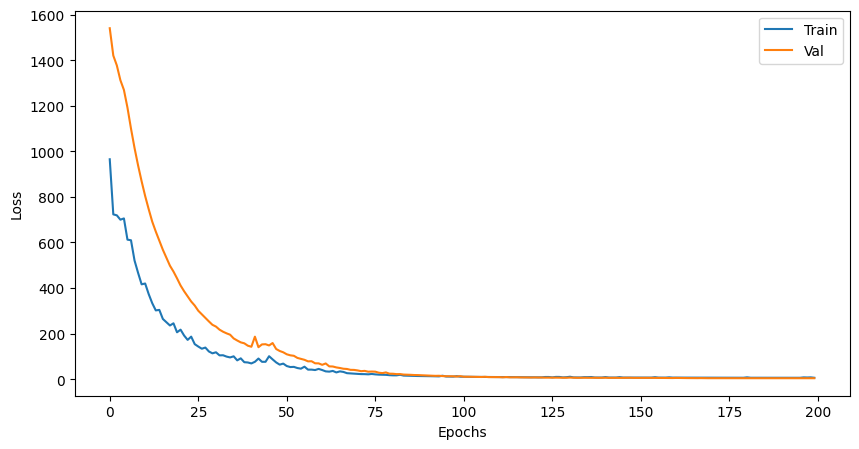

In [776]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

In [777]:
# Load the trained weights
model.load_state_dict(torch.load('best_model.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

pred_value = []
actual_value = []

with torch.no_grad():
    for features, labels in test_loader:
        features = features.cuda()
        outputs = model(features).squeeze(-1)
        pred_value.append(outputs.cpu())
        actual_value.append(labels)

pred_value = torch.cat(pred_value)
actual_value = torch.cat(actual_value)
print("Test MSE: {:.4f}".format(torch.mean(torch.abs(pred_value - actual_value)).item()))

Test MSE: 1.5441


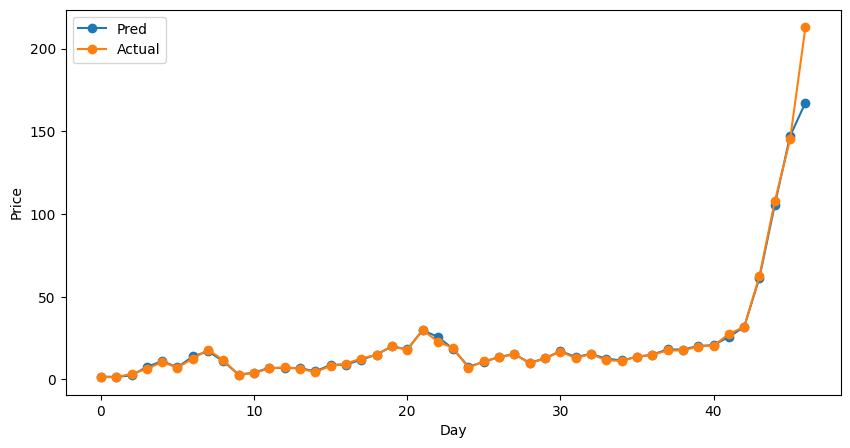

In [778]:
plt.figure(figsize=(10, 5))
plt.plot(pred_value[:], marker='o')
plt.plot(actual_value[:], marker='o')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend(['Pred', 'Actual'])

plt.show()